# Semantic change in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic change in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [137]:
!pip install gensim==4.0

Import libraries

In [138]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

# Parameters

I set the parameters of the analysis.

In [139]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [140]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_in

"/Users/barbaramcgillivray/OneDrive - King's College London/Research/2022/Nexus Linguarum WG4 UC4.2/LatinISE"

I define the list of all files:

In [141]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [142]:
len(files)

1146

We only want IntraText files:

In [143]:
files = [f for f in files[:] if "IT" in f]
len(files)

553

I read the metadata file:

In [144]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]

In [145]:
metadata_df.shape

(670, 5)

In [146]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type'], dtype='object')

In [147]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382
19       -9
20      524
21     1254
22     1254
       ... 
683     116
684     116
685     116
686     116
687     533
Name: date, Length: 670, dtype: int64>

In [148]:
metadata_df.head

<bound method NDFrame.head of              id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  
18                                          Hieronymus   382  poetry  
19                               Ovidius Naso, Publius    -9  poetry  
20                                Benedictus Nursianus   524   prose  
21                             Thomas Aquinas: Sanctus  1254   prose  
22            

Number of works per year:

In [149]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

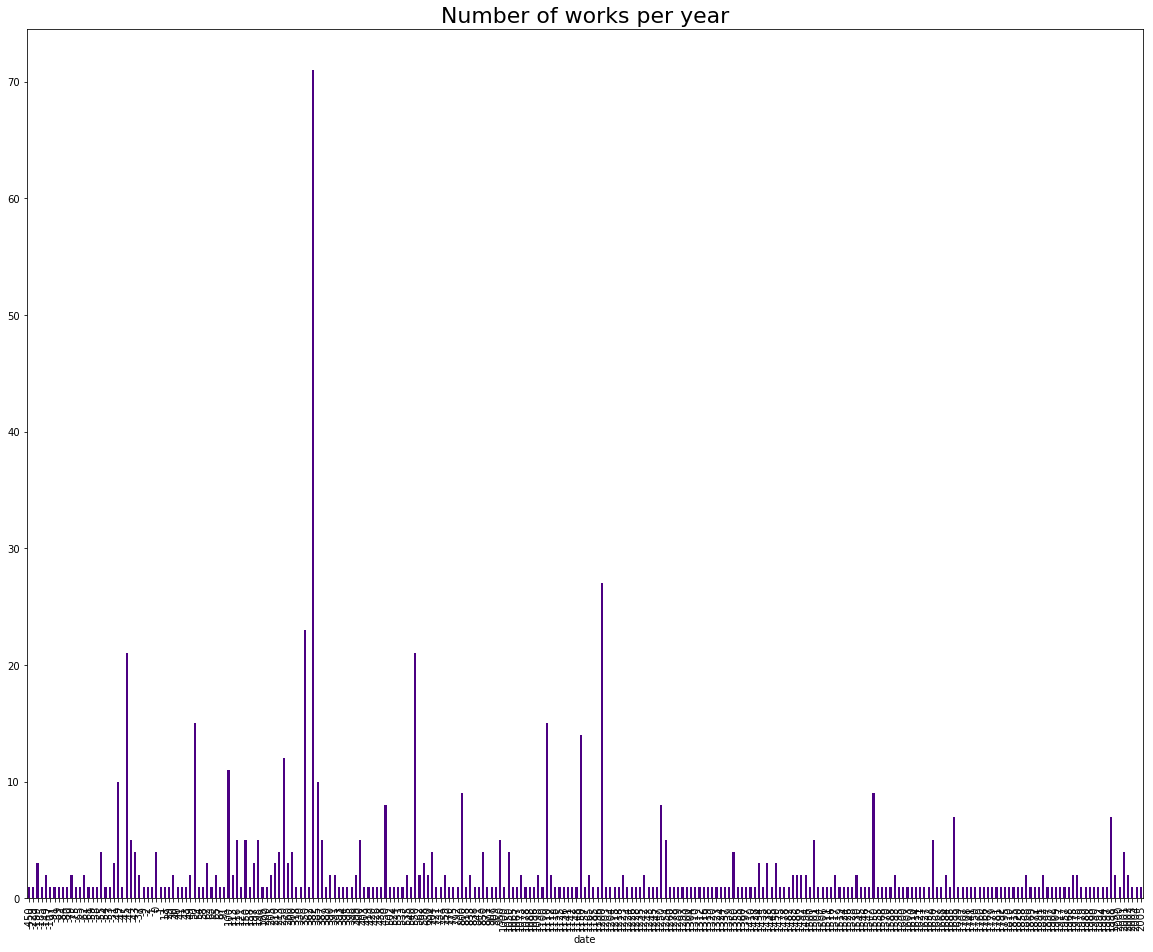

In [150]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Train word embeddings for each time period


Find the first and last year in the dataset:

In [151]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


Define size of the time intervals:

In [152]:
size_interval = 100

So there are

In [153]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

25

time intervals.

Define the time periods and split the corpus:

In [154]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, -350, -250, -150, -50, 50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950, 2050]


Add a column to the metadata_df for the time interval:

In [155]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, -350)
169   -450
Name: date, dtype: int64
1
range(-350, -250)
Series([], Name: date, dtype: int64)
2
range(-250, -150)
137   -199
219   -199
232   -199
605   -185
649   -229
Name: date, dtype: int64
3
range(-150, -50)
57     -80
58     -79
59     -61
60     -51
79     -75
80     -65
81     -62
82     -62
84     -58
88     -55
89     -55
90     -55
91     -53
92     -54
127    -59
129    -55
130    -84
141    -89
154    -51
213    -91
215   -149
223    -79
322    -51
635   -149
638   -107
Name: date, dtype: int64
4
range(-50, 50)
19     -9
34    -49
38     49
39    -45
42    -49
48     49
50      0
54     40
61    -43
62    -43
64    -43
65      0
67    -49
70     43
73     41
76     -2
83      0
93    -45
94    -45
95    -44
97     -1
98     29
103   -43
110   -45
111   -45
112   -45
113   -45
114     0
115   -45
116   -45
119   -45
121   -45
124   -45
125   -45
126   -45
128   -45
131   -45
133   -45
135   -45
142   -49
143   -49
151   -47
152   -44
164   -49
166    13
1

,id,title,creator,date,type,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,350
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,-50
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,450
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,1250
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,1250
...,...,...,...,...,...,...
683,IT-LAT0534,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
684,IT-LAT0534,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
685,IT-LAT0534,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,50
686,IT-LAT0534,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,50


Visualise distribution of time intervals:

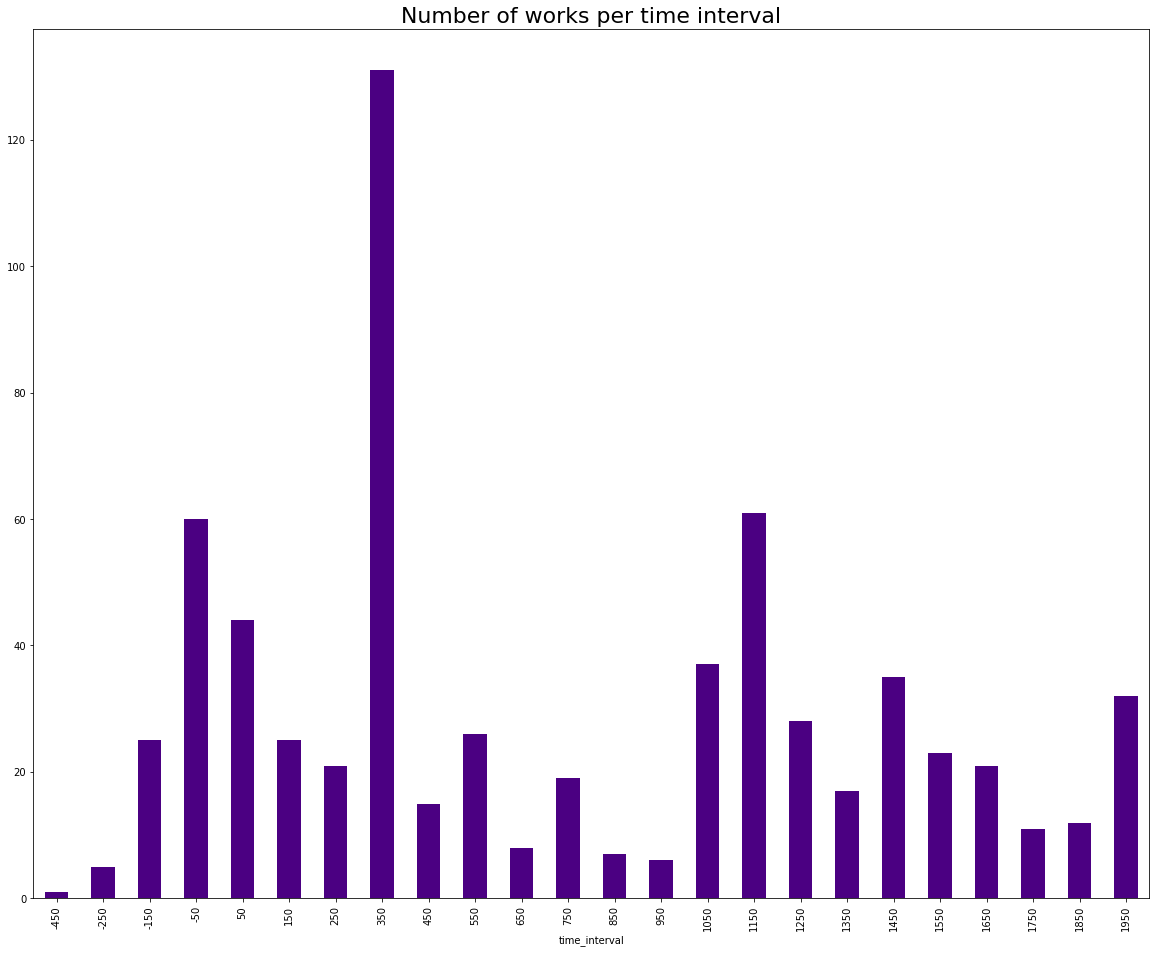

In [156]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

WE MAY WANT TO DO SOMETHING ABOUT THIS INBALANCE

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training word embeddings

Function for printing the vocabulary of a model

In [157]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [158]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [159]:
punctuation = ['.', ',', '...', ';', ':']

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [164]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals+1):
    files_corpus_t = metadata_df.loc[metadata_df['time_interval'] == intervals[t]]
    print("1:",files_corpus_t, type(files_corpus_t))
    corpus_t = list()
    for index, df_line in files_corpus_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus[t] = corpus_t


1:              id                title      creator  date   type time_interval
169  IT-LAT0285  XII Tabularum Leges  [Anonymous]  -450  prose          -450 <class 'pandas.core.frame.DataFrame'>
1: Empty DataFrame
Columns: [id, title, creator, date, type, time_interval]
Index: [] <class 'pandas.core.frame.DataFrame'>
1:              id                               title                  creator  \
137  IT-LAT0236                           Orationes     Cato Porcius, Marcus   
219  IT-LAT0380                   Decretum Hastense  Aemilius Paulus, Lucius   
232  IT-LAT0405                      De agricultura     Cato Porcius, Marcus   
605  IT-LAT0952  Senatus consultum de Bacchanalibus           Auctores varii   
649  IT-LAT1006                           Praecepta    Marcius Vates, Gnaeus   

     date    type time_interval  
137  -199   prose          -250  
219  -199  poetry          -250  
232  -199   prose          -250  
605  -185   prose          -250  
649  -229   prose          

1:              id                                   title  \
40   IT-LAT0051                                 Fabulae   
41   IT-LAT0054                          Vitae Caesarum   
46   IT-LAT0563                                  Silvae   
47   IT-LAT0071                 De tranquillitate animi   
49   IT-LAT0073                          De providentia   
51   IT-LAT0078                                 De otio   
52   IT-LAT0079                           De vita beata   
68   IT-LAT0109                               Agamemnon   
69   IT-LAT0111                     Panegyricus Traiano   
71   IT-LAT0114                              Achilleida   
77   IT-LAT0120            De grammaticis et rhetoribus   
100  IT-LAT0588               Opuscula rerum rusticarum   
101  IT-LAT0588                            Strategemata   
132  IT-LAT0228            Apocolocyntosis Divi Claudii   
134  IT-LAT0230           Epistulae morales ad Lucilium   
138  IT-LAT0237                                   Ili

1:              id                                              title  \
20   IT-LAT0011                                S. Benedicti Regula   
148  IT-LAT0250                                           De Anima   
149  IT-LAT0251                    Epistulae Theodoricianae variae   
150  IT-LAT0252                                          Orationes   
185  IT-LAT0333                                   De centum metris   
186  IT-LAT0334                                  De metris Horatii   
187  IT-LAT0336                         Explanatio in artem Donati   
238  IT-LAT0414                              A solis ortus cardine   
378  IT-LAT0608                                     De laude eremi   
381  IT-LAT0611                                             Ecloga   
541  IT-LAT0867                                              Codex   
570  IT-LAT0904  Adversus profanas omnium novitates haereticoru...   
582  IT-LAT0917                       Porphyrii Isagoge translatio   
645  IT-LAT1001  

1:              id                                              title  \
25   IT-LAT0017                                         Laus solis   
26   IT-LAT0018                Confirmatio fratrum minorum regulae   
273  IT-LAT0466  Planctus destructionis regni Hungariae per Tar...   
278  IT-LAT0479                                            Carmina   
289  IT-LAT0496                De luce seu de inchoatione formarum   
..          ...                                                ...   
550  IT-LAT0877                                 De contemptu mundi   
556  IT-LAT0885                                          Dies irae   
567  IT-LAT0901   Historia rerum in partibus transmarinis gestarum   
571  IT-LAT0905                                Libellus historicus   
583  IT-LAT0918                 De reductione artium ad theologiam   

                       creator  date    type time_interval  
25   Francesco d'Assisi: Santo  1224  poetry          1150  
26           Papa Honorius III  11

1:              id                                              title  \
364  IT-LAT0591               Ethica ordine geometrico demonstrata   
368  IT-LAT0595                                          Oratio VI   
391  IT-LAT0624            Pax Guglielmi auspiciis Europae reddita   
392  IT-LAT0625                               Barometri descriptio   
393  IT-LAT0626         Praelium inter pygmaeos et grues commissum   
394  IT-LAT0627  Resurrectio delineata ad altare Coll. Magd. Oxon.   
395  IT-LAT0628                                     Sphaeristerium   
396  IT-LAT0629   Ad D. D. Hannes, insignissimum medicum et poetam   
397  IT-LAT0630                             Machinae gesticulantes   
398  IT-LAT0631  Ad insignissimum virum D. Tho. Burnettum sacra...   
401  IT-LAT0634                                        Melancholia   
403  IT-LAT0636   Ad Iulius Orstenam de more unguendorum cadaverum   
412  IT-LAT0645                               In quintum Novembris   
416  IT-LAT0652  

1: Empty DataFrame
Columns: [id, title, creator, date, type, time_interval]
Index: [] <class 'pandas.core.frame.DataFrame'>


Let's inspect the corpus for the first time interval:

In [179]:
time2corpus[0]

[['si', 'in', 'ius', 'voco', 'eo'],
 ['ni', 'eo', 'antesto'],
 ['igitur', 'is', 'capio'],
 ['si', 'calvo', 'pes', 've', 'struo', 'manus', 'endo', 'iacito'],
 ['si', 'morbus', 'aevitasve', 'vitium', 'sum', 'iumentum', 'do'],
 ['si', 'nolo', 'arcera', 'ne#2', 'sterno'],
 ['assiduus', 'vindex', 'assiduus', 'sum'],
 ['proletarius', 'iam', 'cieo', 'quis#2', 'volo', 'vindex', 'sum'],
 ['nex', 'fortis', 'sano', 'res', 'ubi', 'paco', 'oro'],
 ['ni',
  'paco',
  'in',
  'comitium',
  'aut',
  'in',
  'forum',
  'ante',
  'meridies',
  'causa',
  'coicio'],
 ['com', 'peroro', 'ambo', 'praesens'],
 ['post', 'meridies', 'praesens', 'lis', 'addicio'],
 ['si', 'ambo', 'praesens', 'sol', 'occido#2', 'superus', 'tempestas', 'sum'],
 ['actor', 'dico#2', 'ex', 'sponsio', 'tu', 'ego', 'do', 'oportet', 'ajo'],
 ['quando',
  'tuuus',
  'nego',
  'tu',
  'praetor',
  'iudex',
  'sive',
  'arbitrum',
  'postulo',
  'uti',
  'do'],
 [],
 ['morbus',
  'sonticus',
  'aut',
  'status',
  'dies',
  'cum',
  'host

And the second:

In [180]:
time2corpus[1]

[]

And the third:

In [182]:
print(str(time2corpus[2]))

[['cogito', 'cum', 'anima', 'vetris', 'si', 'quis#2', 'vos', 'per', 'labor', 'rectus', 'facio', 'labor', 'ille', 'ab', 'vos', 'cito', 'recedo', 'bene', 'facio', 'vos', 'dum', 'vivo', 'non', 'abscedo', 'sed', 'si', 'quis#2', 'per', 'voluptas', 'nequiter', 'facio', 'voluptas', 'cito', 'abeo', 'nequiter', 'facio', 'ille', 'apud', 'vos', 'smeper', 'maneo'], ['magnus', 'seorsum', 'atque', 'divorto', 'pretium', 'paro#2', 'bonus', 'atque', 'strenuus', 'decurionatus', 'optionatus', 'hasta', 'donaticas', 'aliosque', 'honor'], ['Asperirime', 'atque', 'arduissimo', 'aditus'], ['Antiochus', 'epistula', 'bellum', 'gero', 'calamus', 'et', 'atramentum', 'milito'], ['Egoque', 'iam', 'pridem', 'cognosco', 'atque', 'intellego', 'atque', 'arbitror', 'res', 'publicus', 'curo', 'industrie', 'summus', 'periculum', 'sum'], ['atque', 'quamquam', 'multus', 'novus', 'miraculum', 'facio', 'inimicus', 'meus', 'tamen', 'nequeo', 'desino', 'miror', 'is', 'audacia', 'atque', 'confidentiam'], ['is', 'reus', 'do', 'op

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

I train FastText embeddings from the texts. 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020)

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


In [183]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
model = FastText(vector_size=100, window=10, min_count=3)  # instantiate
model.build_vocab(corpus_iterable=time2corpus[0][0])
model.train(corpus_iterable=time2corpus[0][0], total_examples=len(time2corpus[0][0]), epochs=10)  # train
#model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 1 seconds


In [184]:
print_vocab(model, 100)

word #0/2 is o
word #1/2 is i


I now check the similar words to "dies":

In [185]:
model.wv.similar_by_word('dies', 10)

[('i', 0.15906298160552979), ('o', -0.1526741087436676)]

I now train one model for each time interval:

In [99]:
models = list()
start = time.time()
for t in range(len(time2corpus)):
    print(t)
    if len(time2corpus[t])>0:
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=10, min_count=3)  # instantiate
        model.build_vocab(corpus_iterable=time2corpus[t][0])
        model.train(corpus_iterable=time2corpus[t][0], total_examples=len(time2corpus[t][0]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds")

0
1
2
3
4
5
6
7
8


RuntimeError: you must first build vocabulary before training the model

Let's check some models:

In [42]:
print_vocab(models[0], 20)

word #0/31 is .
word #1/31 is ,
word #2/31 is ...
word #3/31 is si
word #4/31 is ;
word #5/31 is esto
word #6/31 is ne
word #7/31 is in
word #8/31 is ni
word #9/31 is cum
word #10/31 is qui
word #11/31 is aut
word #12/31 is volet
word #13/31 is dies
word #14/31 is se
word #15/31 is escit
word #16/31 is dato
word #17/31 is ius
word #18/31 is neve


In [49]:
models[0].wv.similar_by_word('dies', 10)

[('volet', 0.24126018583774567),
 (';', 0.14060211181640625),
 ('ius', 0.10539568960666656),
 ('esto', 0.09501276910305023),
 ('in', 0.08913788944482803),
 (',', 0.08735428005456924),
 ('escit', 0.07665599882602692),
 ('uti', 0.07507738471031189),
 ('si', 0.05550557002425194),
 ('se', 0.05193779617547989)]

In [43]:
print_vocab(models[1], 20)

word #0/31 is .
word #1/31 is ,
word #2/31 is ...
word #3/31 is si
word #4/31 is ;
word #5/31 is esto
word #6/31 is ne
word #7/31 is in
word #8/31 is ni
word #9/31 is cum
word #10/31 is qui
word #11/31 is aut
word #12/31 is volet
word #13/31 is dies
word #14/31 is se
word #15/31 is escit
word #16/31 is dato
word #17/31 is ius
word #18/31 is neve


In [45]:
print_vocab(models[25], 20)

word #0/31 is .
word #1/31 is ,
word #2/31 is ...
word #3/31 is si
word #4/31 is ;
word #5/31 is esto
word #6/31 is ne
word #7/31 is in
word #8/31 is ni
word #9/31 is cum
word #10/31 is qui
word #11/31 is aut
word #12/31 is volet
word #13/31 is dies
word #14/31 is se
word #15/31 is escit
word #16/31 is dato
word #17/31 is ius
word #18/31 is neve


# Semantic change with cosine similarity

I train two word2vec models, one for each dataframe corresponding to a time period. I choose the parameters that led to the best model (see script 1_Corpus_Processing script). This takes approximately 5 minutes. **You can skip this cell.**

In [ ]:
model1 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
model2 = gensim.models.Word2Vec(df2['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)

Save the models. **You can skip this cell.**

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
models = [model1, model2]
models_names = ["model1", "model2"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

I load the models:

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
model1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model1"))
model2 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model2"))
models = [model1, model2]
models_names = ["model1", "model2"]

What are the vocabularies of these models?

In [ ]:
print_vocab(model1, 10)

In [ ]:
print_vocab(model2,10)

In [ ]:
print(str(len(list(model1.wv.index_to_key))))
print(str(len(list(model2.wv.index_to_key))))

The intersection between the vocabularies of the two models:

In [ ]:
vocab1 = set(list(model1.wv.index_to_key))
vocab2 = set(list(model2.wv.index_to_key))
len(vocab1.intersection(vocab2))

## Step 3. Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords <https://github.com/williamleif/histwords>.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [ ]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Then, I define a function for aligning two spaces with [Orthogonal Procrustes](https://simonensemble.github.io/2018-10/orthogonal-procrustes.html):

In [ ]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

Now I can apply the function to my models:

In [ ]:
smart_procrustes_align_gensim(model1, model2, words=None)

Now the two models have been aligned and have the same vocabulary:

In [ ]:
len(model1.wv.index_to_key)

In [ ]:
len(model2.wv.index_to_key)

In [ ]:
model1.wv.index_to_key == model2.wv.index_to_key

I print the vocabulary:

In [ ]:
model1.wv.index_to_key

I save the aligned models:

In [ ]:
for i in range(len(models)):
  print(models_names[i])
  models[i].save(os.path.join(models_folder, models_names[i] + "_aligned"))

Let's look at the similarity between two words in the two spaces:

In [ ]:
model1.wv.similarity("letter", "note")

In [ ]:
model2.wv.similarity("letter", "note")

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in the first time period and the embedding of the same word in the second time period. 

Let's define a function that calculates the cosine similarity between the embedding of a word in t1 and the embedding of the same word in t2:

In [ ]:
def cosine_similarity(word):
  sc = 1-spatial.distance.cosine(model1.wv[word], model2.wv[word])
  return sc

Now I calculate the semantic similarity for all words in the vocabulary, and store this in the dataframe cosine_similarity; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [ ]:
cosine_similarity_df = pd.DataFrame(([w, cosine_similarity(w), model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in model1.wv.index_to_key), columns = ('Word', 'Cosine_similarity', "Frequency_t1", "Frequency_t2"))
cosine_similarity_df

Visualise the distribution of the semantic similarity scores with a histogram:

In [ ]:
hist = cosine_similarity_df['Cosine_similarity'].hist()

Now I sort by decreasing semantic change score:

In [ ]:
cosine_similarity_df_sorted = cosine_similarity_df.sort_values(by='Cosine_similarity', ascending=True)
cosine_similarity_df_sorted.head()

I add the total frequency:

In [ ]:
cosine_similarity_df_sorted["Total_Frequency"] = cosine_similarity_df_sorted["Frequency_t1"]+cosine_similarity_df_sorted["Frequency_t2"]
cosine_similarity_df_sorted

I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [ ]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [ ]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

In [ ]:
# create a list of our conditions
conditions = [
    (cosine_similarity_df_sorted['Word'].isin(function_words)), # function words
    ((cosine_similarity_df_sorted.Word.str.isdigit()) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?1st$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?2nd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?3rd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (cosine_similarity_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(cosine_similarity_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
cosine_similarity_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
cosine_similarity_df_sorted

I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
cosine_similarity_df_sorted.to_csv(os.path.join(output_folder, 'Cosine_similarity_all_words.csv'), encoding='utf-8')

The top most changed words:

In [ ]:
cosine_similarity_df_sorted.head(100)

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] =="scientist"]

I plot the terms by their total frequency and semantic change score:

In [ ]:
ax = cosine_similarity_df_sorted.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

Which words are the outliers? Function words and *Darwin*:

In [ ]:
cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] > 10000].Word.tolist()

I exclude the outliers:

In [ ]:
cosine_similarity_df_sorted_nooutliers = cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] < 10000]
cosine_similarity_df_sorted_nooutliers.shape

Plot:

In [ ]:
ax = cosine_similarity_df_sorted_nooutliers.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [ ]:
words_chosen = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve']

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] == "scientist"]


In [ ]:
cosine_similarity_chosen = cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'].isin(words_chosen)]
cosine_similarity_chosen.to_csv(os.path.join(output_folder, 'cosine_similarity_chosen_words.csv'), encoding='utf-8')
cosine_similarity_chosen

In [ ]:
min(cosine_similarity_chosen.Cosine_similarity)

In [ ]:
min(cosine_similarity_chosen.Total_Frequency)

In [ ]:
min(cosine_similarity_df_sorted.Cosine_similarity)

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency). How many are there?

In [ ]:
cosine_similarity_df_sorted_filtered = cosine_similarity_df_sorted_nooutliers.loc[(cosine_similarity_df_sorted_nooutliers['Total_Frequency'] >= min(cosine_similarity_chosen.Total_Frequency))]
cosine_similarity_df_sorted_filtered.shape

Which words are these words?

In [ ]:
cosine_similarity_df_sorted_filtered

Neighbours of *fertilisation* in the two time periods:

In [ ]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
cosine_similarity_df_sorted_filtered[cosine_similarity_df_sorted_filtered['Word'] == "fertilisation"]

I create a list for these words:

In [ ]:
highfreq_words = cosine_similarity_df_sorted_filtered.Word.tolist()
highfreq_words[:10]

Now I annotate the plot with these:

In [ ]:
cosine_similarity_df_sorted_filtered_p = cosine_similarity_df_sorted_filtered[['Word','Cosine_similarity', 'Total_Frequency']]
fig, ax = plt.subplots()
cosine_similarity_df_sorted_filtered_p.plot('Cosine_similarity', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in cosine_similarity_df_sorted_filtered_p.iterrows():
  word = v['Word']
  sc = v['Cosine_similarity']
  f = v['Total_Frequency']
  #print("w", v['Word'])
  #print("sc:", str(sc))
  #print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [ ]:
count = 0
for word in highfreq_words:
  count += 1
  if count < 10:
    print(word)
    print("Neighbours in first space:")
    print(model1.wv.similar_by_word(word, 10))
    print("Neighbours in second space:")
    print(model2.wv.similar_by_word(word, 10))

I print this to an output file:

In [ ]:
outfile = open(os.path.join(output_folder, 'Neighbours_freq_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in highfreq_words:
  #print(word)
  #print("Neighbours in first space:")
  #print(model1.wv.similar_by_word(word, 10))
  #print("Neighbours in second space:")
  #print(model2.wv.similar_by_word(word, 10))
  for (w,c) in model1.wv.similar_by_word(word, 10):
    outfile.write(word+"\t" + w+"\t"+str(c))
  outfile.write("\n")
  for (w,c) in model2.wv.similar_by_word(word, 10):
    outfile.write(word+"\t"+w+"\t"+str(c))
  outfile.write("\n")
  
outfile.close()

## Semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

Print the histogram of the frequency of the words in the corpus:

In [ ]:
model = sg_w5_f1
vocab = model.wv.index_to_key
frequencies = list()
for w in vocab:
  frequencies.append(model.wv.get_vecattr(w, "count"))
print(pd.DataFrame({'Word':vocab,'Freq':frequencies}).describe())
pd.DataFrame({'Word':vocab,'Freq':frequencies}).hist()

I exclude all words with frequency lower than min_freq and higher than max_freq:

In [ ]:
def filter_words(model, min_freq, max_freq):
  vocab = model.wv.index_to_key
  vocab_filtered = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") <max_freq and model.wv.get_vecattr(w, "count")>min_freq:
      vocab_filtered.append(w)
  return vocab_filtered

vocab1_filtered = filter_words(model1,2,50000)
vocab2_filtered = filter_words(model2,2,50000)
vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))

How many words?

In [ ]:
print(str(len(vocab_filtered)))

Distribution of filtered word frequencies:

In [ ]:
word2freq = pd.DataFrame({'Word':vocab,'Freq':frequencies})
print(word2freq[(word2freq.Freq<100000) & (word2freq.Freq>3)].describe())
word2freq[(word2freq.Freq<50000) & (word2freq.Freq>2)].hist()

I extract the top_n neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [ ]:
def extract_neighbours(w2vmodel, vocab_list, top_n):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    #if (count % 100) == 0:
    #  print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, top_n)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 for filtered words:

In [ ]:
#word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours1 = extract_neighbours(model1, vocab1_filtered, 100)
#word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, vocab2_filtered, 100)

For every word in the intersection between the two vocabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [ ]:
#vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_filtered:
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [ ]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted[:10]

What are the most changed words?

In [ ]:
top_changed = [i[0] for i in w2sc_sorted][:20]
top_changed

What are their neighbours?

In [ ]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

In [ ]:
neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
neighbours_df.describe()

Visualise the distribution of the semantic change scores with a histogram:

In [ ]:
hist = neighbours_df['Neighbour_score'].hist()

Now I sort by increasing neighbour score:

In [ ]:
neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
neighbours_df_sorted.head(50)

I add the total frequency:

In [ ]:
neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
neighbours_df_sorted

I add a column with the category (function word, foreign word, numeral, and proper noun).

In [ ]:
# create a list of our conditions
conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
neighbours_df_sorted

I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [ ]:
neighbours_df_sorted.sort_values(by='Word', ascending=True)

In [ ]:
cosine_similarity_df_sorted.sort_values(by='Word', ascending=True)

In [ ]:
semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
semantic_change_2methods

I integrate the neighbour score in the file:

In [ ]:
semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'] =="scientist"]

I plot the terms by two semantic change scores:

In [ ]:
ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')

In [ ]:
semantic_change_2methods_all.corr(method="spearman")

There seems to be a positive correlation: the higher the cosine similarity the higher the neighbour similarity.



In [ ]:
semantic_change_2methods_all.describe()

Scores for chosen words:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Scores for not chosen words:

In [ ]:
semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Compare the two means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]]

I define a list of words that I expect did not change:

In [ ]:
not_changed = ['the', 'it', 'for', 'a', 'at', 'in', 'be', 'of', 'on', 'over', 'under']

Then I look at their scores:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)]

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].describe()

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

Let's look at species:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='species']

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='descent']

I compare the means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]]

### Systematic comparison of cosine similarity and neighbour similarity by different values of parameters

This is the list of non-scientific words currently analysed in the article:

In [ ]:
nonsci_analysed = ['lunch', 'presentation', 'herewith', 'heartfelt', 'presentation', 'inconvenient']

This is the list of scientific words currently analysed in the article:

In [ ]:
sci_analysed = ['molecule', 'fundamental', 'spiritual', 'latent', 'wriggle', 'sediment']

I define a function that, given a minimum frequency, a maximum frequency and the number of top neighbours, does the following: filter the vocabularies, apply this to model1 and model2 for filtered words, calculates the neghbour similarity score, define a dataframe with this score, save to a file, combine the dataframe with the cosine similarity score, I plot the terms by two semantic change scores, calculate Spearman correlation between the two scores, compares the means of the two scores for the chosen words (gold standard), the words that did not change, the words that were not in the gold standard, the non-scientific words currently analysed in the article and the scientific words currently analysed in the article.

In [ ]:
def compare_two_methods(min_freq, max_freq, top_n):
  vocab1_filtered = filter_words(model1,min_freq, max_freq)
  vocab2_filtered = filter_words(model2,min_freq, max_freq)
  #print("Vocabulary 1 filtered: "+str(len(vocab1_filtered)))
  #print("Vocabulary 2 filtered: "+str(len(vocab2_filtered)))
  vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))
  #print("1")
  word2neighbours1 = extract_neighbours(model1, vocab1_filtered, top_n)
  #print("2")
  word2neighbours2 = extract_neighbours(model2, vocab2_filtered, top_n)
  #print("3")
  w2sc = dict()
  for w in vocab_filtered:
    sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
    w2sc[w] = sc
  #print("4")
  w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
  neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
  #print("5")
  #print("6")
  neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
  #print("7")
  neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
  #print("8")
  conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]
  # create a list of the values we want to assign for each condition
  values = ['Function word','Numeral', 'Proper noun', 'Foreign word']
  neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
  #print("9")
  neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("10")
  semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
  #print("11")
  semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
  #print("12")
  semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("13")
  ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')
  #print("14")
  corr = (semantic_change_2methods_all.corr(method="spearman")).Neighbour_score[0]
  #print("Correlation:",corr)
  #print("Means of chosen words:")
  mean_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of all other words:")
  mean_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of not changed words:")
  mean_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0]][0]
  mean_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[4]][0]
  median_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[0]][0]
  median_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]])
  #print("Means of non-scientific words currently analysed in the article:")
  mean_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0]][0]
  mean_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[4]][0]
  median_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[0]][0]
  median_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0,4]])
  #print("Means of scientific words currently analysed in the article:")
  mean_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0]][0]
  mean_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[4]][0]
  median_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[0]][0]
  median_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0,4]])
  return [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
          mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
          median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian,median_nei_scian]

I try different parameters:

In [ ]:
summary = open(os.path.join(output_folder, 'summary_results.csv'), 'w+')
writer = csv.writer(summary, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
writer.writerow(['min_freq','max_freq', 'top_n', 'vocab1_filtered', 'vocab2_filtered', 
                 'Spearman correlation cosine_sim-neighbour_sim', 
                 'mean_neighbourscore_chosen_words','mean_cosinescore_chosen_words',
                 'mean_neighbourscore_other_words','mean_cosinescore_other_words',
                 'mean_neighbourscore_unchanged_words','mean_cosinescore_unchanged_words',
                 'mean_neighbourscore_non_sci_words_analysed','mean_cosinescore_non_sci_words_analysed',
                 'mean_neighbourscore_sci_words_analysed','mean_cosinescore_sci_words_analysed',
                 'median_neighbourscore_chosen_words','median_cosinescore_chosen_words',
                 'median_neighbourscore_other_words','median_cosinescore_other_words',
                 'median_neighbourscore_unchanged_words','median_cosinescore_unchanged_words',
                 'median_neighbourscore_non_sci_words_analysed','median_cosinescore_non_sci_words_analysed',
                 'median_neighbourscore_sci_words_analysed','median_cosinescore_sci_words_analysed'])
min_freq_values = [0,1,5,10,50]
max_freq_values = [10000,100000,200000]
top_n_values = [10,50,100,1000]
for min_freq in min_freq_values:
  for max_freq in max_freq_values:
    for top_n in top_n_values:
      print(min_freq, max_freq, top_n)
      [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
       mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
       median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian, median_nei_scian] = compare_two_methods(min_freq, max_freq, top_n)
      writer.writerow([min_freq, max_freq, top_n, len(vocab1_filtered), len(vocab2_filtered), corr,
                 mean_cos_chosen,mean_nei_chosen,mean_cos_other,mean_nei_other,mean_cos_unchanged,mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian,mean_cos_scian,mean_nei_scian,
                 median_cos_chosen,median_nei_chosen,median_cos_other,median_nei_other,median_cos_unchanged,median_nei_unchanged, median_cos_nonscian, median_nei_nonscian,median_cos_scian,median_nei_scian])
summary.close()